In [1]:
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [2]:
DATA_DIR = './data/ml-latest-small/'
dfm = pd.read_csv(DATA_DIR+'movies.csv')
df = pd.read_csv(DATA_DIR+'ratings.csv')
df = df.merge(dfm, on='movieId', how='left')
df = df.sort_values(['userId', 'timestamp'], ascending=[True, True]).reset_index(drop=True)
df.head(3)

,userId,movieId,rating,timestamp,title,genres
0,1,804,4.0,964980499,She's the One (1996),Comedy|Romance
1,1,1210,5.0,964980499,Star Wars: Episode VI - Return of the Jedi (1983),Action|Adventure|Sci-Fi
2,1,2018,5.0,964980523,Bambi (1942),Animation|Children|Drama


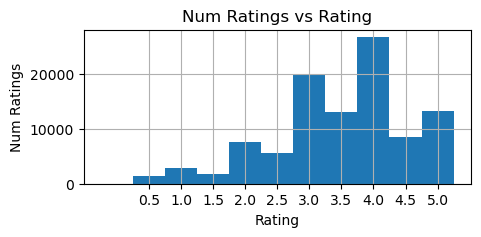

In [3]:
plt.figure(figsize=(5,2))
bins = np.arange(0,6,0.5)-0.25
plt.hist(df.rating.values, bins=bins);
plt.xticks(np.arange(0.5, 5.5, 0.5)); plt.grid();
plt.title('Num Ratings vs Rating');
plt.xlabel('Rating'); plt.ylabel('Num Ratings');

In [4]:
# Use LabelEncoder to convert users and movies into categorical
# This step also remaps each column integer range to [0, len(df.column.unique())-1]
# Remapping is useful to reduce memory size of nn.embeddings
d = defaultdict(LabelEncoder)
cols_cat = ['userId', 'movieId']
for c in cols_cat:
    d[c].fit(df[c].unique())
    df[c] = d[c].transform(df[c])
    print(f'# unique {c}: {len(d[c].classes_)}')

min_num_ratings = df.groupby(['userId'])['userId'].transform(len).min()
print(f'Min # of ratings per user: {min_num_ratings}')
print(f'Min/Max rating: {df.rating.min()}/{df.rating.max()}, df.shape: {df.shape}')
df.head(3)

# unique userId: 610
# unique movieId: 9724
Min # of ratings per user: 20
Min/Max rating: 0.5/5.0, df.shape: (100836, 6)


,userId,movieId,rating,timestamp,title,genres
0,0,632,4.0,964980499,She's the One (1996),Comedy|Romance
1,0,910,5.0,964980499,Star Wars: Episode VI - Return of the Jedi (1983),Action|Adventure|Sci-Fi
2,0,1492,5.0,964980523,Bambi (1942),Animation|Children|Drama


In [5]:
# Make train and val dataset
# 610 unique users. Each user has minimum 20 rated movies
# For val dataset, use last 5 rated movies per user
df_train = df.groupby('userId').head(-5).reset_index(drop=True)
df_val = df.groupby('userId').tail(5).reset_index(drop=True)
print(df_train.shape, df_val.shape)

(97786, 6) (3050, 6)


In [6]:
class MovieDataset(Dataset):
    def __init__(self, df):
        self.df = df[['userId', 'movieId', 'rating']]
        self.x = [x for x in zip(df.userId.values, df.movieId.values)]
        self.y = self.df.rating.values
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

In [7]:
bs = 8192
ds_train = MovieDataset(df_train)
ds_val = MovieDataset(df_val)
dl_train = DataLoader(ds_train, bs, shuffle=True, num_workers=4)
dl_val = DataLoader(ds_val, bs, shuffle=True, num_workers=4)

xb, yb = next(iter(dl_train))
xb, yb

([tensor([ 74, 122, 447,  ..., 176, 609,   9]),
  tensor([ 905, 1938, 8067,  ..., 2697, 1374, 8988])],
 tensor([3.5000, 4.0000, 3.0000,  ..., 3.0000, 5.0000, 5.0000],
        dtype=torch.float64))

In [8]:
class MF(nn.Module):
    def __init__(self, num_users, num_items, emb_dim):
        super().__init__()
        self.user_emb = nn.Embedding(num_embeddings=num_users, embedding_dim=emb_dim)
        self.item_emb = nn.Embedding(num_embeddings=num_items, embedding_dim=emb_dim)
    def forward(self, user, item):
        user_emb = self.user_emb(user)
        item_emb = self.item_emb(item)
        element_product = (user_emb*item_emb).sum(1)
        return element_product

In [9]:
num_users = len(df.userId.unique())
num_items = len(df.movieId.unique())
mdl = MF(num_users, num_items, emb_dim=32)
mdl

MF(
  (user_emb): Embedding(610, 32)
  (item_emb): Embedding(9724, 32)
)

In [10]:
lr = 0.2
num_epochs = 10

opt = optim.Adam(mdl.parameters(), lr=lr)
loss_fn = nn.MSELoss()
epoch_train_losses, epoch_val_losses = [], []

for i in range(num_epochs):
    train_losses, val_losses = [], []
    
    mdl.train()
    for xb,yb in dl_train:
        xUser, xItem = xb[0].long(), xb[1].long()
        yRatings = yb.float()
        preds = mdl(xUser, xItem)
        loss = loss_fn(preds, yRatings)
        train_losses.append(loss.item())
        opt.zero_grad()
        loss.backward()
        opt.step()
        
    mdl.eval()
    for xb,yb in dl_val:
        xUser, xItem = xb[0].long(), xb[1].long()
        yRatings = yb.float()
        preds = mdl(xUser, xItem)
        loss = loss_fn(preds, yRatings)
        val_losses.append(loss.item())
        
    epoch_train_loss = np.mean(train_losses)
    epoch_val_loss = np.mean(val_losses)
    epoch_train_losses.append(epoch_train_loss)
    epoch_val_losses.append(epoch_val_loss)
    print(f'Epoch: {i}, Train Loss: {epoch_train_loss:0.1f}, Val Loss:{epoch_val_loss:0.1f}')

Epoch: 0, Train Loss: 25.5, Val Loss:21.2
Epoch: 1, Train Loss: 7.2, Val Loss:11.9
Epoch: 2, Train Loss: 3.4, Val Loss:6.9
Epoch: 3, Train Loss: 1.8, Val Loss:4.7
Epoch: 4, Train Loss: 1.1, Val Loss:3.7
Epoch: 5, Train Loss: 0.8, Val Loss:3.3
Epoch: 6, Train Loss: 0.7, Val Loss:3.1
Epoch: 7, Train Loss: 0.6, Val Loss:3.1
Epoch: 8, Train Loss: 0.5, Val Loss:3.1
Epoch: 9, Train Loss: 0.5, Val Loss:3.0


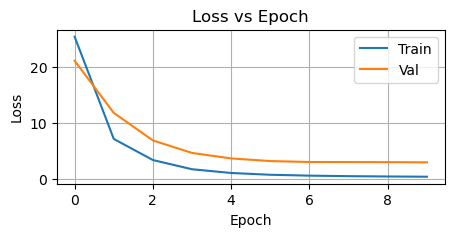

In [11]:
plt.figure(figsize=(5,2))
plt.plot(epoch_train_losses, label='Train')
plt.plot(epoch_val_losses, label='Val')
plt.title('Loss vs Epoch');
plt.xlabel('Epoch'); plt.ylabel('Loss')
plt.grid(); plt.legend();

In [12]:
user_emb_min_w = mdl.user_emb.weight.min().item()
user_emb_max_w = mdl.user_emb.weight.max().item()
item_emb_min_w = mdl.item_emb.weight.min().item()
item_emb_max_w = mdl.item_emb.weight.max().item()
print(f'Emb user min/max w: {user_emb_min_w:0.3f} / {user_emb_max_w:0.3f}')
print(f'Emb item min/max w: {item_emb_min_w:0.3f} / {item_emb_max_w:0.3f}')
print(f'Preds min/max: {preds.min().item():0.2f} / {preds.max().item():0.2f}')
print(f'Rating min/max: {yRatings.min().item():0.2f} / {yRatings.max().item():0.2f}')
print(preds.detach().numpy()[:6])
print(yRatings.detach().numpy()[:6])

Emb user min/max w: -2.529 / 2.646
Emb item min/max w: -6.897 / 6.557
Preds min/max: -5.02 / 14.40
Rating min/max: 0.50 / 5.00
[1.4845339 4.20778   3.5969088 3.3696399 3.3176925 3.9816945]
[2.  4.5 3.  3.5 5.  4. ]
